# Linear Regression for a Non-Linear Features-Target Relationship

In this notebook, we show that even if the parametrization of linear models is not natively adapted to the problem at hand, it is still possible to make linear models more expressive by engineering additional features.

A machine learning pipeline that combines a non-linear feature engineering step followed by a linear regression step can therefore be considered non-linear regression model as a whole.

To illustrate these concepts, we will reuse the same dataset generated in the previous exercise.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
sns.set(context='talk', style='whitegrid',
       palette='coolwarm', rc={"figure.figsize": (8, 6)})

In [3]:
rng = np.random.RandomState(0)
n_sample = 100
data_max, data_min = 1.4, -1.4
len_data = (data_max - data_min)

In [4]:
# sort the data to make plotting easier later
data = np.sort(rng.rand(n_sample)*len_data - len_data / 2)
noise = rng.randn(n_sample) * .3
target = data ** 3 - .5 * data **2 + noise

In [5]:
# data and target as dataframe
full_data = pd.DataFrame({"input_feature": data, "target": target})

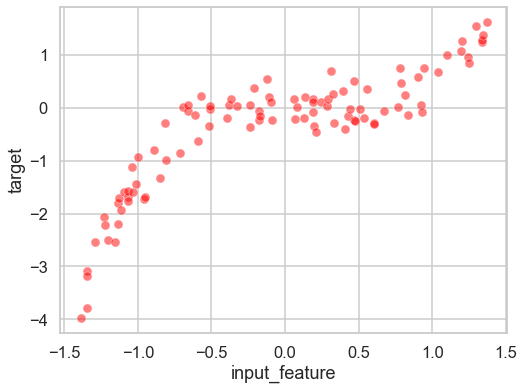

In [6]:
# visualize the data
sns.scatterplot(data=full_data, x="input_feature", y="target",
                     color='red', alpha=0.5);

We will first highlight the limitations of fitting a linear regression model as done in the previous exercise.

In [7]:
# X should be 2D for sklearn: (n_samples, n_features)
data = data.reshape((-1, 1))
data.shape

(100, 1)

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [9]:
linear_regression = LinearRegression()
linear_regression.fit(data, target)
target_predicted = linear_regression.predict(data)

In [10]:
mse = mean_squared_error(target, target_predicted)

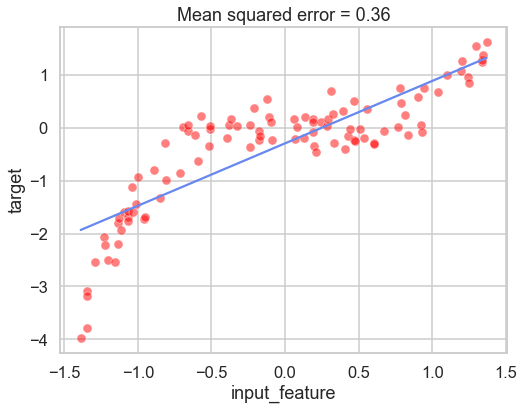

In [11]:
ax = sns.scatterplot(data=full_data, x="input_feature", y="target",
                      color='red', alpha=0.5)
ax.plot(data, target_predicted)
ax.set_title(f"Mean squared error = {mse:.2f}");

Here the coefficient and intercept learnt by `LinearRegression` define the best "straight line" that fits the data. We can inspect the coefficients using the attributes of the learned model as follows:

In [12]:
print(f"weight: {linear_regression.coef_[0]:.2f}, "
      f"intercept: {linear_regression.intercept_:.2f}")

weight: 1.18, intercept: -0.29


It is important to note that the learned model will not be able to handle the non-linear relationship between `data` and `target` since linear models assume the relationship between `data` and `target` to be linear.  

Indeed, there are 3 possibilities to solve this issue:

1. choose a model that can inherently handle with non-linearity,
2. engineer a richer set of features by including expert knowledge which can be directly used by a simple linear model, or
3. use a "kernel" to have a locally-based decision function instead of a global linear decision function.  

Let's illustrate quickly the first point by using a decision tree regressor which can natively handle non-linearity.

In [13]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3).fit(data, target)
target_predicted = tree.predict(data)
mse = mean_squared_error(target, target_predicted)

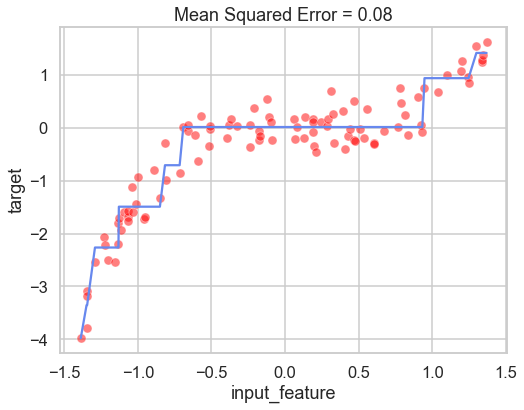

In [14]:
ax = sns.scatterplot(data=full_data, x="input_feature", 
                     y="target", color='red', alpha=.5)
ax.plot(data, target_predicted)
ax.set_title(f"Mean Squared Error = {mse:.2f}");

Instead of having a model which can deal with non-linearity, we could also modify our data: we could create new features derived from the original features, using some expert knowledge. In this example, we know that we have a cubic and squared relationship between `data` and `target` (because we generated the data). 

Indeed, we could create two new features (`data ** 2` and `data ** 3`) using this information as follows. This kind of transformation is called a <code style="background:yellow;color:black">polynomial feature expansion:</code>

In [15]:
data.shape

(100, 1)

In [16]:
data_expanded = np.concatenate([data, data**2, data**3], axis=1)
data_expanded.shape

(100, 3)

In [17]:
linear_regression.fit(data_expanded, target)
target_predicted = linear_regression.predict(data_expanded)
mse = mean_squared_error(target, target_predicted)

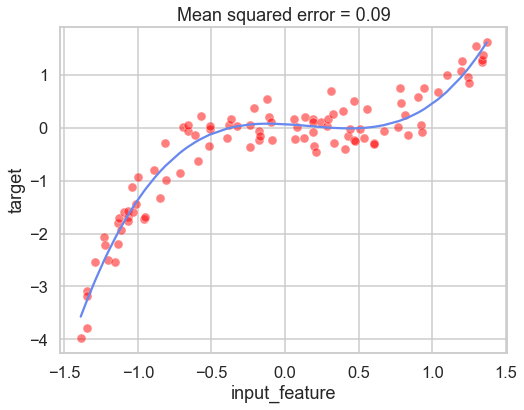

In [18]:
ax = sns.scatterplot(data=full_data, x='input_feature', 
                     y='target', color='red', alpha=0.5)
ax.plot(data, target_predicted)
ax.set_title(f"Mean squared error = {mse:.2f}");

We can see that even with a linear model, we can overcome the linearity limitation of the model by adding the non-linear components in the design of additional features. Here, we created new features by knowing the way the target was generated.

Instead of manually creating such polynomial features on could directly use `sklearn.preprocessing.PolynomialFeatures`.

To demonstrate the use of the `PolynomialFeatures` class, we use a scikit-learn pipeline which first transforms the features and then fit the regression model.

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [20]:
polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=3),
    LinearRegression(),
)
polynomial_regression.fit(data, target)
target_predicted = polynomial_regression.predict(data)
mse = mean_squared_error(target, target_predicted)

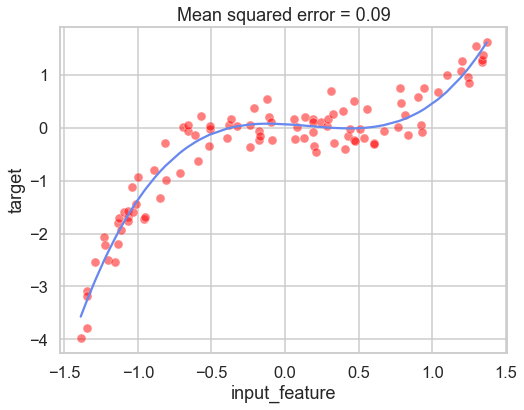

In [21]:
ax = sns.scatterplot(data=full_data, x='input_feature', 
                     y='target', color='red', alpha=0.5)
ax.plot(data, target_predicted)
ax.set_title(f"Mean squared error = {mse:.2f}");

As expected, we observe that the predictions of the this `PolynomialFeatures` pipeline match the predictions of the linear model fit on manually engineered features.

The last possibility to make a linear model more expressive is to use a "kernel". Instead of learning a weight per feature as we previously emphasized, a weight will be assign by sample instead. However, not all samples will be used. This is the base of the support vector machine algorithm.

Let's develop first some intuitions on the relative expressive power of support vector machines with linear and non-linear kernels by fitting them on the same dataset.


First, consider a support vector machine with a linear kernel:

In [22]:
from sklearn.svm import SVR

svr = SVR(kernel='linear')
svr.fit(data, target)
target_predicted = svr.predict(data)
mse = mean_squared_error(target, target_predicted)

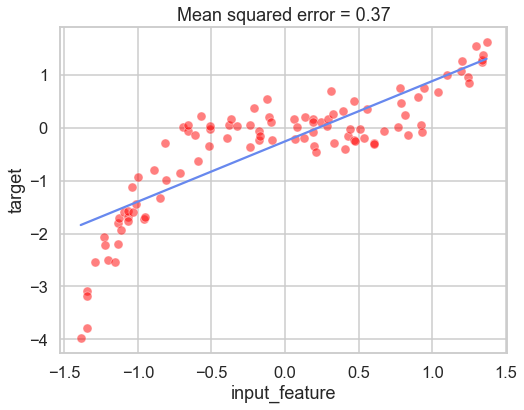

In [23]:
ax = sns.scatterplot(data=full_data, x="input_feature", 
                     y="target", color='red', alpha=0.5)
ax.plot(data, target_predicted)
ax.set_title(f"Mean squared error = {mse:.2f}");

The predictions of our SVR with a linear kernel are all aligned on a straight line. `SVR(kernel="linear")` is indeed yet another example of a linear model.   

The estimator can also be configured to use a non-linear kernel. Then, it can learn a prediction function that computes non-linear interaction between samples for which we want to make a predictions and selected samples from the training set.

The result is another kind of non-linear regression model with a similar expressivity as our previous polynomial regression pipeline:

In [24]:
svr = SVR(kernel='poly', degree=3)
svr.fit(data, target)
target_predicted = svr.predict(data)
mse = mean_squared_error(target, target_predicted)

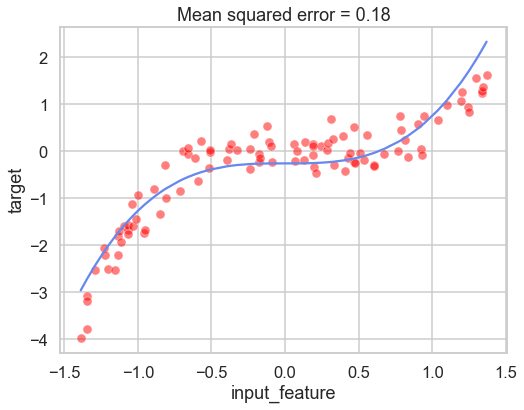

In [25]:
ax = sns.scatterplot(data=full_data, x='input_feature', 
                     y='target', color='red', alpha=0.5)
ax.plot(data, target_predicted)
ax.set_title(f"Mean squared error = {mse:.2f}");

Kernel methods such as SVR are very efficient for small to medium datasets.

For larger datasets with `n_samples >> 10_000`, it is often computationally more efficient to perform explicit feature expansion using `PolynomialFeatures` or other non-linear transformers from scikit-learn such as `KBinsDiscretizer` or `Nystroem`.

The following gives an intuitive overview of the predictions we would get using those on our dataset. For more info, please refer to the scikit-learn documentation.

In [26]:
from sklearn.preprocessing import KBinsDiscretizer

binned_regression = make_pipeline(
                KBinsDiscretizer(n_bins=8), LinearRegression())

binned_regression.fit(data, target)
target_predicted = binned_regression.predict(data)
mse = mean_squared_error(target, target_predicted)


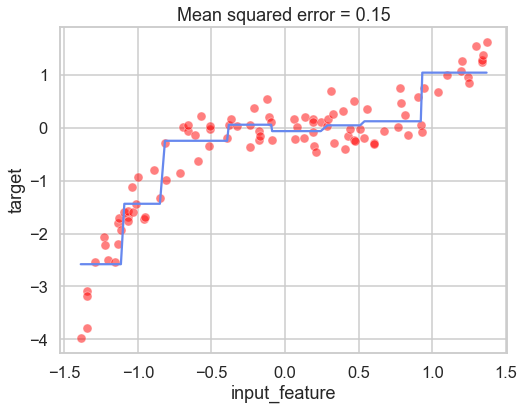

In [28]:
ax = sns.scatterplot(data=full_data, x='input_feature', y='target',
                    color='r', alpha=.5)
ax.plot(data, target_predicted)
ax.set_title(f'Mean squared error = {mse:.2f}');

In [29]:
from sklearn.kernel_approximation import Nystroem

nystroem_regression = make_pipeline(
        Nystroem(n_components=5), LinearRegression())
nystroem_regression.fit(data, target)
target_predicted = nystroem_regression.predict(data)

In [ ]:
mse = mean_squared_error(target, target_predicted)
ax = sns.scatterplot(data=full_data, x='input_')